# Portfolio Risk Dashboard

 exploratory statistics

## Setup
Install the dependencies listed in `requirements.txt` and make sure the Excel file is placed alongside this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../src")

from risk_analysis.data import load_price_history, compute_log_returns
from risk_analysis.portfolio import (
    compute_portfolio_statistics,
    rolling_var_estimates,
    summarize_var_violations,
)

%matplotlib inline

## Load price history and compute daily log returns

In [2]:
prices = load_price_history('cleaned_adj_close_data.xlsx')
return_dates, asset_returns = compute_log_returns(prices)
asset_returns.head()

Ticker,AMZN,MSFT,NVDA,GOOGL,AAPL,IBM
Date,,,,,,
2014-01-03,-0.003852,-0.006750,-0.012052,-0.007322,-0.022211,0.005964
2014-01-06,-0.007113,-0.021359,0.013312,0.011088,0.005438,-0.003434
2014-01-07,0.011116,0.007720,0.016240,0.019095,-0.007177,0.019750
2014-01-08,0.009726,-0.018014,0.013539,0.002079,0.006313,-0.009214
2014-01-09,-0.002267,-0.006453,-0.037999,-0.009677,-0.012852,-0.003144


## Portfolio statistics

In [3]:
portfolio_returns, asset_stats, portfolio_summary = compute_portfolio_statistics(asset_returns)
asset_stats

,mean,std,skew,kurt
Ticker,,,,
AMZN,0.000871,0.020591,-0.022054,9.079479
MSFT,0.000946,0.016689,-0.174696,11.184233
NVDA,0.002136,0.029352,0.224799,10.302292
GOOGL,0.000698,0.017545,0.010624,9.187287
AAPL,0.000970,0.017584,-0.212203,8.717318
IBM,0.000243,0.014736,-0.707858,13.762014


In [4]:
portfolio_summary

PortfolioSummary(mean_return=0.000977164779755353, std_return=0.015075916059664586, skewness=-0.4438476238892959, kurtosis=8.803712414461902, min_return=-0.12762647152149778, max_return=0.0922207992488803, jb_statistic=3955.7836891512143, jb_pvalue=0.0)

### Portfolio return distribution

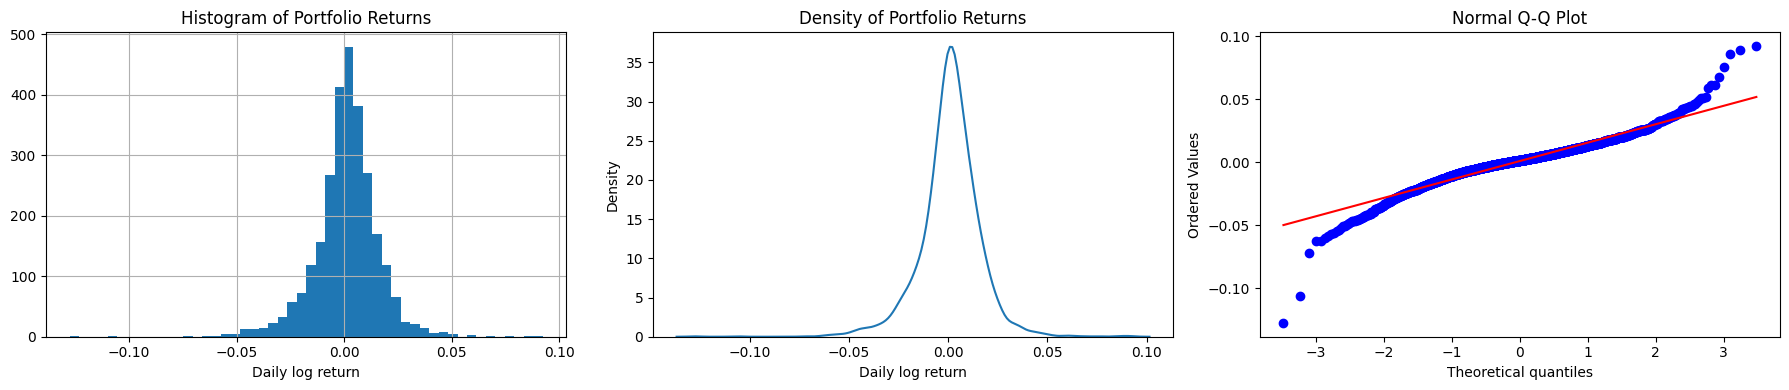

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
portfolio_returns.hist(bins=50, ax=axes[0])
axes[0].set_title('Histogram of Portfolio Returns')
axes[0].set_xlabel('Daily log return')

sns.kdeplot(portfolio_returns, ax=axes[1])
axes[1].set_title('Density of Portfolio Returns')
axes[1].set_xlabel('Daily log return')

from scipy.stats import probplot
probplot(portfolio_returns, dist='norm', plot=axes[2])
axes[2].set_title('Normal Q-Q Plot')
plt.tight_layout()

## Rolling VaR estimates

In [6]:
var_table = rolling_var_estimates(portfolio_returns)
var_table.tail()

,HS_90,HS_99,Normal_90,Normal_99,MC_90,MC_99,CF_90,CF_99,BSHS_90,BSHS_99,T_90,T_99
Date,,,,,,,,,,,,
2024-12-23,-0.016064,-0.035669,-0.016068,-0.029977,-0.016139,-0.029750,-0.016065,-0.041459,-0.016146,-0.036446,-0.015254,-0.032113
2024-12-24,-0.016050,-0.035639,-0.015965,-0.029834,-0.016440,-0.029973,-0.015951,-0.041486,-0.016146,-0.036446,-0.015139,-0.031992
2024-12-26,-0.016064,-0.035669,-0.015842,-0.029665,-0.015005,-0.028637,-0.015783,-0.041836,-0.016146,-0.036446,-0.014978,-0.031902
2024-12-27,-0.016064,-0.035669,-0.015907,-0.029709,-0.015981,-0.029997,-0.015827,-0.041722,-0.016146,-0.036446,-0.015044,-0.031944
2024-12-30,-0.016078,-0.035699,-0.016067,-0.029966,-0.016058,-0.029706,-0.016050,-0.041702,-0.016146,-0.036446,-0.015236,-0.032138


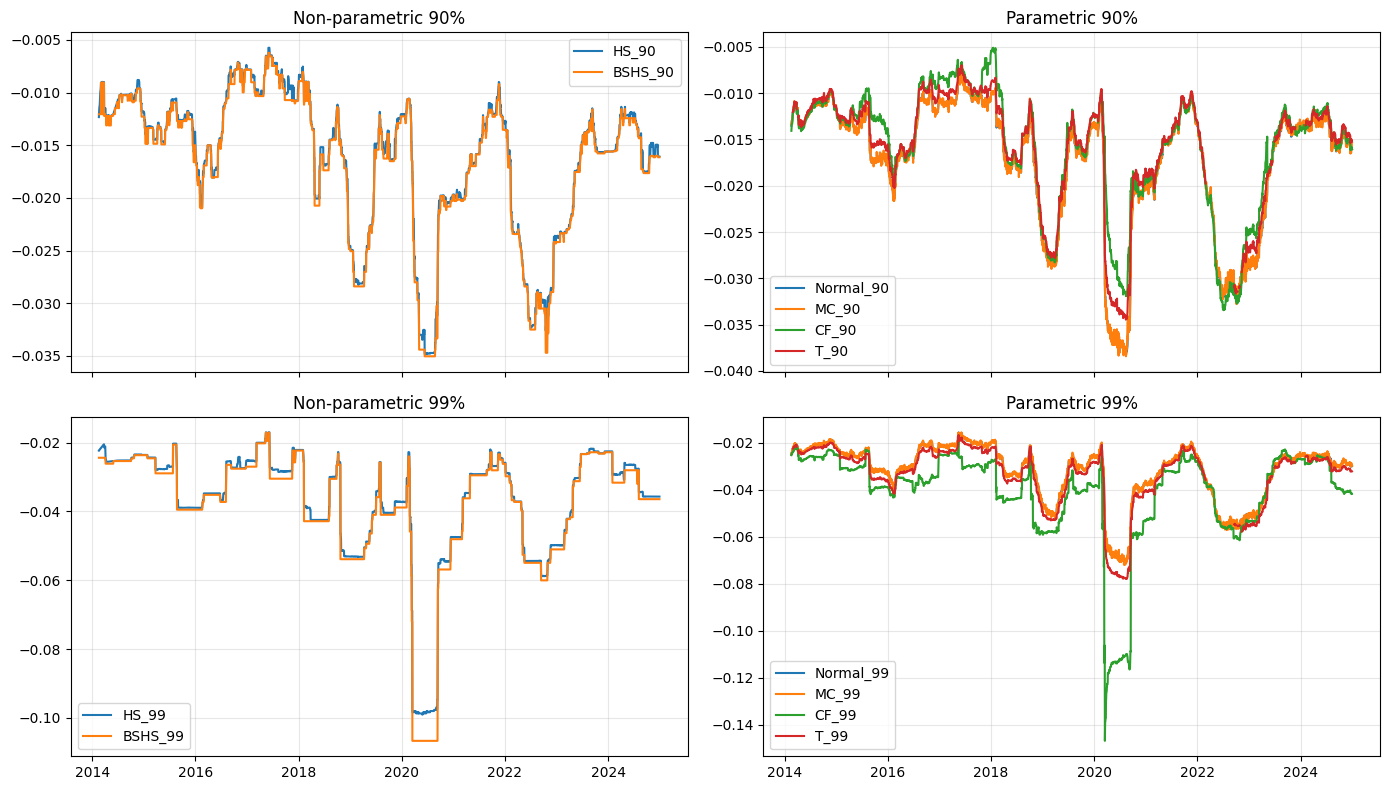

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
for ax, group, title in zip(
    axes.flatten(),
    [['HS_90', 'BSHS_90'], ['Normal_90', 'MC_90', 'CF_90', 'T_90'], ['HS_99', 'BSHS_99'], ['Normal_99', 'MC_99', 'CF_99', 'T_99']],
    ['Non-parametric 90%', 'Parametric 90%', 'Non-parametric 99%', 'Parametric 99%']
):
    for col in group:
        if col in var_table:
            ax.plot(var_table.index, var_table[col], label=col)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
plt.tight_layout()

## VaR backtesting

In [8]:
violations = summarize_var_violations(portfolio_returns, var_table)
violations

,NumViolations,NumValidDays,ViolationFraction
VaR_Method,,,
HS_90,284,2736,0.103801
HS_99,46,2736,0.016813
Normal_90,266,2736,0.097222
Normal_99,81,2736,0.029605
MC_90,265,2736,0.096857
MC_99,81,2736,0.029605
CF_90,293,2736,0.107091
CF_99,32,2736,0.011696
BSHS_90,273,2736,0.099781
